In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy, IndpPGPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [3]:
class test_network(nn.Module):

    def __init__(self, device="cpu", in_channels=9, feature_dim=27, out_channels=1, padding_mode="circular"):
        super().__init__()
        self.device = device
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=feature_dim, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=feature_dim, out_channels=feature_dim, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=feature_dim, out_channels=out_channels, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=self.device)
        batch = obs.shape[0]

        values = self.model(obs.reshape(batch, -1, 128, 128))
        values = values.reshape(batch,128,128)
        return values
    

class fcnn(nn.Module):
    def __init__(self):
        super(fcnn, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 27),
            nn.ReLU(),
            nn.Linear(27, 27),
            nn.ReLU(),
            nn.Linear(27,1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
model = test_network()
model2 = fcnn()

In [5]:
print(model.model[0].weight.shape)
print(model.model[0].bias.shape)
print(model.model[2].weight.shape)
print(model.model[2].bias.shape)
print(model.model[4].weight.shape)
print(model.model[4].bias.shape)

print("**********************")

print(model2.model[0].weight.shape)
print(model2.model[0].bias.shape)
print(model2.model[2].weight.shape)
print(model2.model[2].bias.shape)
print(model2.model[4].weight.shape)
print(model2.model[4].bias.shape)

torch.Size([27, 9, 1, 1])
torch.Size([27])
torch.Size([27, 27, 1, 1])
torch.Size([27])
torch.Size([1, 27, 1, 1])
torch.Size([1])
**********************
torch.Size([27, 9])
torch.Size([27])
torch.Size([27, 27])
torch.Size([27])
torch.Size([1, 27])
torch.Size([1])


In [4]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
              99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
              160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:29]
val_seeds = seeds[29:]
#test_seeds = np.array([69, 33, 420])
    
train_env = KolmogorovEnvironment11(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
test_env = KolmogorovEnvironment12(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
#######################################################################################################
####### Policy ########################################################################################
#######################################################################################################
assert train_env.observation_space.shape is not None  # for mypy
assert train_env.action_space.shape is not None
#initialize PPO
actor = MyFCNNActorProb2(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb2(in_channels=2, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=3e-4, eps=1e-7)
dist = torch.distributions.Normal
#dist = ElementwiseNormal

policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=0.9,
    reward_normalization=False, 
    advantage_normalization = False,
    value_clip = False,
    deterministic_eval=True,
    action_scaling= True,
    action_bound_method= "tanh",
    ent_coef = 1e-3,
    vf_coef = 5e-2,
    max_grad_norm = 1.,
    gae_lambda=0.9, 
    recompute_advantage=False,
)

#policy2 = PGPolicy(model=actor, optim=optim, dist_fn=dist, action_space=train_env.action_space,
#        discount_factor=0.9,reward_normalization=False, deterministic_eval=True,
#        observation_space=train_env.observation_space, action_scaling=True, action_bound_method = "tanh",
#    )
#
#policy3 = IndpPGPolicy(model=actor, optim=optim, dist_fn=dist, action_space=train_env.action_space,
#        discount_factor=0.9,reward_normalization=False, deterministic_eval=True,
#        observation_space=train_env.observation_space, action_scaling=True, action_bound_method = "tanh",
#    )


#######################################################################################################
####### Collectors ####################################################################################
#######################################################################################################
#train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, len(train_env)))
train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(20000, 1))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#######################################################################################################
####### Trainer #######################################################################################
#######################################################################################################
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=2,
    step_per_epoch=100,
    repeat_per_collect=1,
    episode_per_test=1,
    batch_size=16,
    step_per_collect=32,
    #episode_per_collect=args.episode_per_collect,
    show_progress=True,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
)

Re=10000, m_prime=1588, T=18.001958690024615, omega=1.9996472117476842
Re=10000, m_prime=25408, T=18.001958690024615, omega=1.99437028369627
Re=10000, m_prime=1588, T=18.001958690024615, omega=1.9996472117476842
Re=10000, m_prime=25408, T=18.001958690024615, omega=1.99437028369627


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")
/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [5]:
f1 = train_env.f1

In [8]:
f1.sum(axis=-1)

Array([[0.99899407, 0.99885964, 0.99875575, ..., 0.99947403, 0.99929776,
        0.99914033],
       [0.99896757, 0.99882941, 0.99872995, ..., 0.99945348, 0.99927165,
        0.99911526],
       [0.99897465, 0.99883537, 0.99874234, ..., 0.99945725, 0.99927183,
        0.9991202 ],
       ...,
       [0.99929339, 0.99918255, 0.99907193, ..., 0.99968987, 0.99956183,
        0.99942792],
       [0.99915964, 0.99903702, 0.99892714, ..., 0.99958763, 0.99944136,
        0.9993003 ],
       [0.99905176, 0.99892249, 0.99881648, ..., 0.9994989 , 0.99933887,
        0.99919358]], dtype=float64)

: 

Re=10000, m_prime=1588, T=18.001958690024615, omega=1.9996472117476842
Re=10000, m_prime=25408, T=18.001958690024615, omega=1.99437028369627
0 0.0
rew =  0.000
Correlation: 0.9987231474849272
MSE: 0.00014821107852688544
NMSE: 0.00011563614360897561
pointwise relative mse: 20.711289247949633


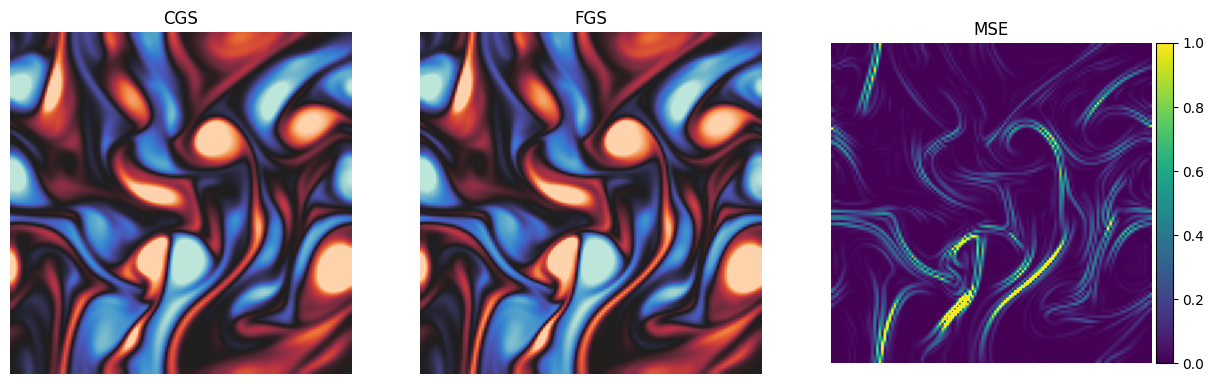

500 1.0
rew =  1.000
Correlation: 0.9963250009484961
MSE: 0.000490643346328165
NMSE: 0.0003853376792155124
pointwise relative mse: 4281.83212826179


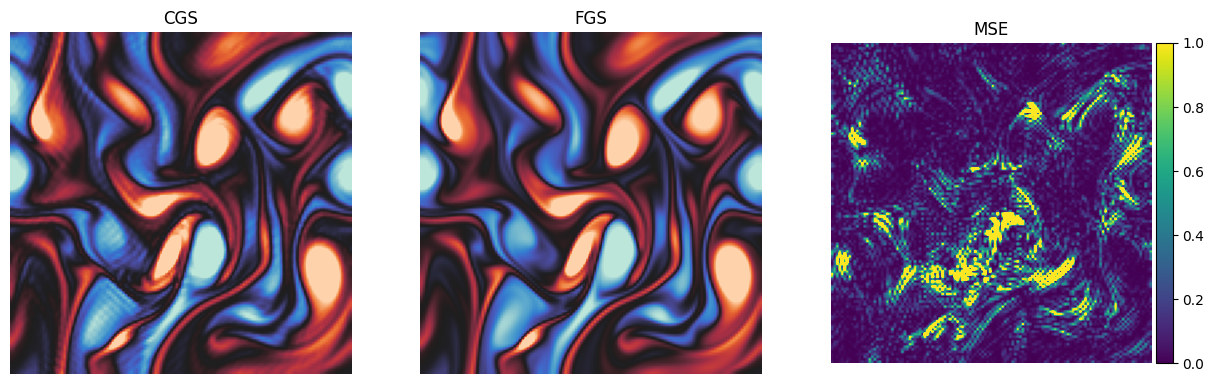

1000 1.0
rew =  1.000
Correlation: 0.9892448797654637
MSE: 0.0017865284232621557
NMSE: 0.0014214728841492406
pointwise relative mse: 40.96475512296571


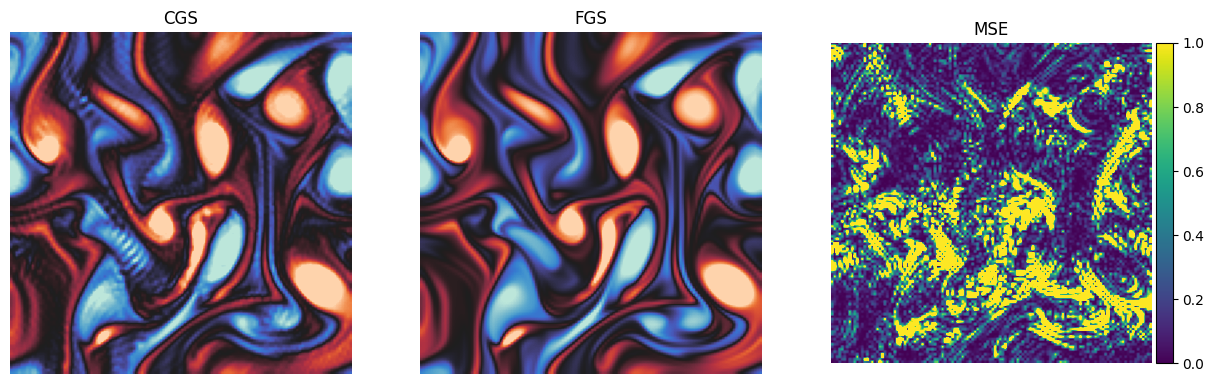

1500 1.0
rew =  1.000
Correlation: 0.9807162431097605
MSE: 0.0037299044428776317
NMSE: 0.003001284590440257
pointwise relative mse: 41.192124643664485


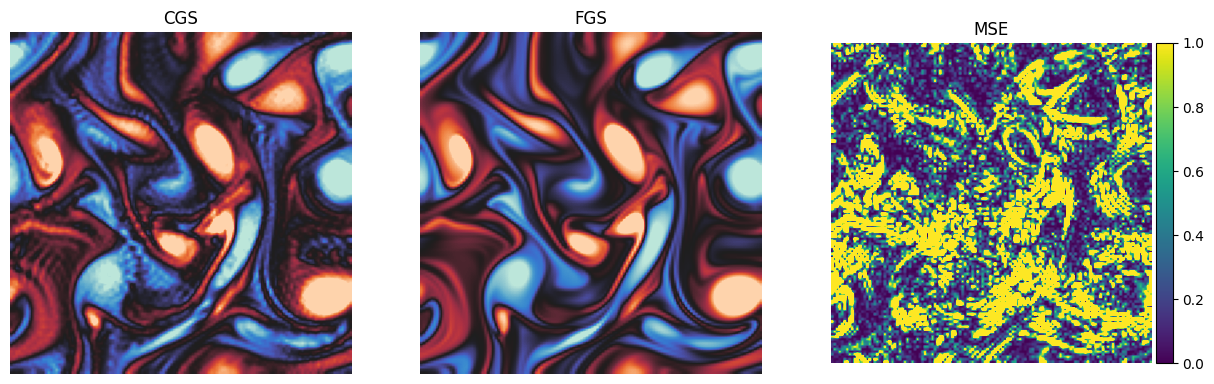

truncated
#steps = 1587, Total Reward = 1620.33333, Total discounted Reward = 33.3333333333332
Execution time: 7.849026441574097 seconds


In [11]:
import time
#time one klmgrv5 episode
env = KolmogorovEnvironment11(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
env = TransformObservation(env, lambda obs: (obs/0.00014))
start_time = time.time()
reward = np.zeros(env.action_space.shape)
discounted_reward = 0
f_min, f_max, f_mean=0.,0.,0.
gamma = 0.97
step = 0
act = np.ones(env.action_space.shape)
#act[32:96, 32:96] = 0.996
obs ,inf = env.reset()
rew = np.zeros(env.action_space.shape)
episode_is_over = False
rews = []
obss = []
while not episode_is_over:
    if step%500==0:
        print(step, rew.mean())
        print("rew = ", f"{rew[100,100]:.3f}")
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        #E1, E2 = env.get_spectra()
        #plt.style.use('ggplot')
        #plt.figure(figsize=(8, 5), dpi=100)
        #plt.loglog(E1, label='cgs')
        #plt.loglog(E2, linestyle='dashed', label='fgs')
        #plt.ylabel(r'Energy spectrum $E(k)$')
        #plt.xlabel(r'wavenumber $k$')
        #plt.legend()
        #plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    rews.append(rew)
    obss.append(obs)
    reward += rew
    discounted_reward += rew * gamma**step 
    f_min = np.min([f_min, obs.min()])
    f_max = np.max([f_min, obs.max()])
    f_mean += obs.mean()
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

f_mean /= step

print(f"#steps = {step}, Total Reward = {reward.mean():.5f}, Total discounted Reward = {discounted_reward.mean()}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [12]:
print(f_min, f_mean, f_max)

-15.742213964886226 4.407997220888668e-14 12.543732183469588


In [13]:
rews = np.array(rews)
obss = np.array(obss)

In [14]:
print(rews.min(), rews.mean(), rews.max(), rews.std())

1.0 1.0210039907582442 34.33333333333331 0.8364758559857113
